In [12]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [23]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hyperopt
import sklearn.metrics as mt
import pickle
from matplotlib import transforms

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

In [14]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function should append to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function should also handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)

    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y

In [15]:
def train_classifier_XGB(X_train, y_train): 
    xgb = XGBClassifier(use_label_encoder=False, eta = 0.7, max_depth= 7, subsample = 1, verbosity = 0)
    xgb.fit(X_train, y_train)
    return xgb

In [16]:
def train_classifier_DNN(X_train, y_train): 
    size = (50,) * 2
    dnn = MLPClassifier(hidden_layer_sizes=size, activation='tanh',
                            solver='adam', learning_rate='invscaling', max_iter=1000)
    dnn.fit(X_train, y_train)
    return dnn

In [17]:
def train_classifier_KNN(X_train, y_train): 
    knn = KNeighborsClassifier(leaf_size=43, p=1, n_neighbors=14)
    knn.fit(X_train, y_train)
    return knn

In [18]:
################################################################################################################
###### Split (X,y) obtained in task 3b (they had window length=10 and spacing=1) into train/test ######
###### sets (80%/20%). Then, call functions train_classifier_XGB() and train_classifier_DNN(). ########
###### Save trained models (returned by the three functions) into .json files. ########################
################################################################################################################'

lbl = [0, 1]

def training_alg(name, X_train, y_train, X_test, y_test):
    model = None
    
    print(f'Training {name}...')
    if name == 'XGB':
        model = train_classifier_XGB(X_train, y_train)
    elif name == 'MLP':
        model = train_classifier_DNN(X_train, y_train)
    elif name == 'KNN':
        model = train_classifier_KNN(X_train, y_train)
        
    # Added to fix: 'XGBClassifier' object has no attribute '_le'
    if (isinstance(model, XGBClassifier)):
        model._le = LabelEncoder().fit(y_test)
            
    y_pred = model.predict(X_test)
    
    accuracy = mt.accuracy_score(y_test, y_pred)
    global_precision = mt.precision_score(y_test, y_pred, labels=lbl, average='weighted')
    global_recall = mt.recall_score(y_test, y_pred, labels=lbl, average='weighted')
    global_f1score = mt.f1_score(y_test, y_pred, labels=lbl, average='weighted')
    
    y_score = model.predict_proba(X_test)[:, 1]
    
    # PR curve
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_score)
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test,  y_score)
    auc = roc_auc_score(y_test, y_score)
    
    
    roc_stats = [fpr, tpr, auc]
    pr_stats = [precision_curve, recall_curve]
    metrics = [accuracy, global_precision, global_recall, global_f1score]
    print(metrics)
    
    stats = [roc_stats, pr_stats, metrics]
    return stats

def training(X, y):
    # Stratify garantees the split all the scenarios among train and test
    # It's like shuffle and split
    # random_state it's a seed to get the same output
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
    
    xgb_stats = training_alg('XGB', X_train, y_train, X_test, y_test)
    dnn_stats = training_alg('MLP', X_train, y_train, X_test, y_test)
    knn_stats = training_alg('KNN', X_train, y_train, X_test, y_test)
    
    return xgb_stats, dnn_stats, knn_stats


In [19]:
def load_dataset_path(folderpath, X, y, spacing, length):
    for filename in os.listdir(folderpath):
        #F: you should continue iterating over "Features" folder looking for the desired files    
        if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
            print(filename)
            label = 0
            if int(filename[9]) > 5:
                label = 1
            fullname = folderpath + '/' + filename
            X, y = load_window_dataset(X, y, fullname, label)
    return X, y

In [20]:
##########################################################################################
###### Use function load_window_dataset() with datasets of for all scenarios  
###### using window length = 10 and spacing = 1. Finally, perform features scaling 
##########################################################################################

X_raw, y_raw=None, None
X_median, y_median=None, None
X_mode, y_mode=None, None
X_mean, y_mean=None, None
X_previous, y_previous=None, None

#All scenario correlated ONLY TO "length=10" and "spacing=1"
length=10
spacing=1

folderpath_raw='../Features_raw'
folderpath_median='../Features_1_5/Features_median_raw_0_1'
folderpath_mode='../Features_1_5/Features_mode_raw_0_1'
folderpath_mean='../Features_1_5/Features_mean_raw_0_1'
folderpath_previous='../Features_1_5/Features_previous_raw_0_1'

print('Loading window dataset for RAW...')
X_raw, y_raw = load_dataset_path(folderpath_raw, X_raw, y_raw, spacing, length)

print('Loading window dataset for MEDIAN...')
X_median, y_median = load_dataset_path(folderpath_median, X_median, y_median, spacing, length)

print('Loading window dataset for MODE...')
X_mode, y_mode = load_dataset_path(folderpath_mode, X_mode, y_mode, spacing, length)

print('Loading window dataset for MEAN...')
X_mean, y_mean = load_dataset_path(folderpath_mean, X_mean, y_mean, spacing, length)

print('Loading window dataset for PREVIOUS...')
X_previous, y_previous = load_dataset_path(folderpath_previous, X_previous, y_previous, spacing, length)

X_raw = StandardScaler().fit_transform(X_raw)
X_median = StandardScaler().fit_transform(X_median)
X_mode = StandardScaler().fit_transform(X_mode)
X_mean = StandardScaler().fit_transform(X_mean)
X_previous = StandardScaler().fit_transform(X_previous)

print('>>> Training RAW...')
xgb_stats_raw, dnn_stats_raw, knn_stats_raw = training(X_raw, y_raw)
print('>>> Training MEDIAN...')
xgb_stats_median, dnn_stats_median, knn_stats_median = training(X_median, y_median)
print('>>> Training MEAN...')
xgb_stats_mean, dnn_stats_mean, knn_stats_mean = training(X_mean, y_mean)
print('>>> Training MODE...')
xgb_stats_mode, dnn_stats_mode, knn_stats_mode = training(X_mode, y_mode)
print('>>> Training PREVIOUS...')
xgb_stats_previous, dnn_stats_previous, knn_stats_previous = training(X_previous, y_previous)


Loading window dataset for RAW...
Scenario_1_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
Scenario_2_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
Scenario_3_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
Scenario_4_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
Scenario_5_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
Scenario_5_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
Scenario_5_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
Scenario_6_monitor_node_1_preamp_lpth_3-2_1_100GHz_sp1_w10.dat
Scenario_6_monitor_node_1_preamp_lpth_3-2_1_12.5GHz_sp1_w10.dat
Scenario_6_monitor_node_1_preamp_lpth_3-2_1_25GHz_sp1_w10.dat
Scenario_7_monitor_node_1_preamp_lpth_2_1_12.5GHz_sp1_w10.dat
Scenario_7_monitor_node_1_preamp_lpth_3-1_1_12.5GHz_s

In [25]:
def plot_roc_curve(fig_folder, alg_name, stats_raw, stats_mean, stats_median, stats_mode, stats_previous):
    # create ROC curve
    fig, ax = plt.subplots(figsize=(10,10))       
    
    stats = [stats_raw, stats_mean, stats_median, stats_mode, stats_previous]
    stats_name = ['Raw' , 'Mean', 'Median', 'Mode', 'Previous']
    
    for i in range(len(stats)):
        transform = transforms.Affine2D().translate(0, -0.00002*i) + ax.transData
        ax.plot(stats[i][0], stats[i][1], label = stats_name[i]+" AUC="+str(stats[i][2]), transform=transform)
    
    ax.set_title(alg_name+' ROC Curve')
    ax.legend(loc=4)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.grid()
    
    ax.set_ylim(0.990, 1)
    ax.set_xlim(0, 0.1) 
    ax.legend(loc='best')
    
    fig.tight_layout()
    fig.savefig(fig_folder+'/'+alg_name+' Raw and Norm ROC Curve'.replace(" ", "_")+'.png')
    plt.show()
    
    
def plot_precision_recall_curve(fig_folder, alg_name, stats_raw, stats_mean, stats_median, stats_mode, stats_previous):
    #create precision recall curve
    fig, ax = plt.subplots(figsize=(10,10))      
    
    stats = [stats_raw, stats_mean, stats_median, stats_mode, stats_previous]
    stats_name = ['Raw' , 'Mean', 'Median', 'Mode', 'Previous']
    
    for i in range(len(stats)):
        transform = transforms.Affine2D().translate(0, -0.00002*i) + ax.transData
        ax.plot(stats[i][1], stats[i][0], label = stats_name[i], transform=transform)
        
    #add axis labels to plot
    ax.set_title(alg_name+' '+stats_name[i]+' Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    ax.grid()
    
    ax.set_ylim(0.990, 1)
    ax.set_xlim(0.980, 1) 
    ax.legend(loc='best')
    
    fig.tight_layout()
    fig.savefig(fig_folder+'/'+alg_name+' Replaced OSNR values Precision-Recall Curve'.replace(" ", "_")+'.png')
    plt.show()

def bar_chart_norm_impact(fig_folder, alg_name, labels, stats_raw, stats_mean, stats_median, stats_mode, stats_previous):
    width = 0.15  # the width of the bars

    r1 = np.arange(len(labels))
    r2 = [x + width for x in r1]
    r3 = [x + width for x in r2]
    r4 = [x + width for x in r3]
    r5 = [x + width for x in r4]
    
    fig, ax = plt.subplots(figsize=(20,8))
    rects1 = ax.bar(r1, stats_raw, width, label='Raw')
    rects2 = ax.bar(r2, stats_mean, width, label='Mean')
    rects3 = ax.bar(r3, stats_mean, width, label='Median')
    rects4 = ax.bar(r4, stats_mean, width, label='Mode')
    rects5 = ax.bar(r5, stats_mean, width, label='Previous')

    ax.set_ylim(0.997, 1)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    image_title = alg_name+' Replaced OSNR values Impact on metrics'
    ax.set_title(image_title)
    ax.set_xticks([r + width*2 for r in range(len(labels))], labels)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

    ax.bar_label(rects1, label_type='edge', padding=3, rotation=20)
    ax.bar_label(rects2, label_type='edge', padding=3, rotation=20)
    ax.bar_label(rects3, label_type='edge', padding=3, rotation=20)
    ax.bar_label(rects4, label_type='edge', padding=3, rotation=20)
    ax.bar_label(rects5, label_type='edge', padding=3, rotation=20)

    ax.grid()
    ax.set_axisbelow(True)
    
    fig.tight_layout()
    fig.savefig(fig_folder+'/'+image_title.replace(" ", "_")+'.png')
    plt.show()

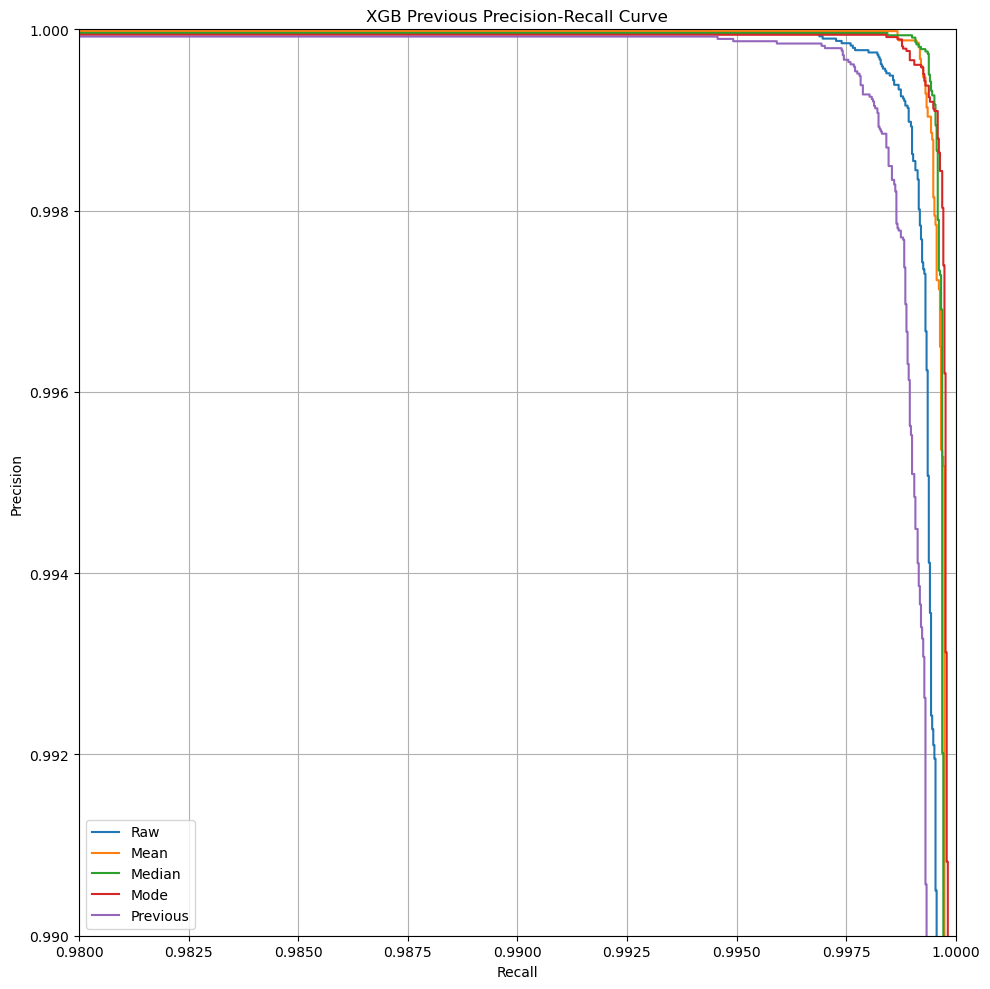

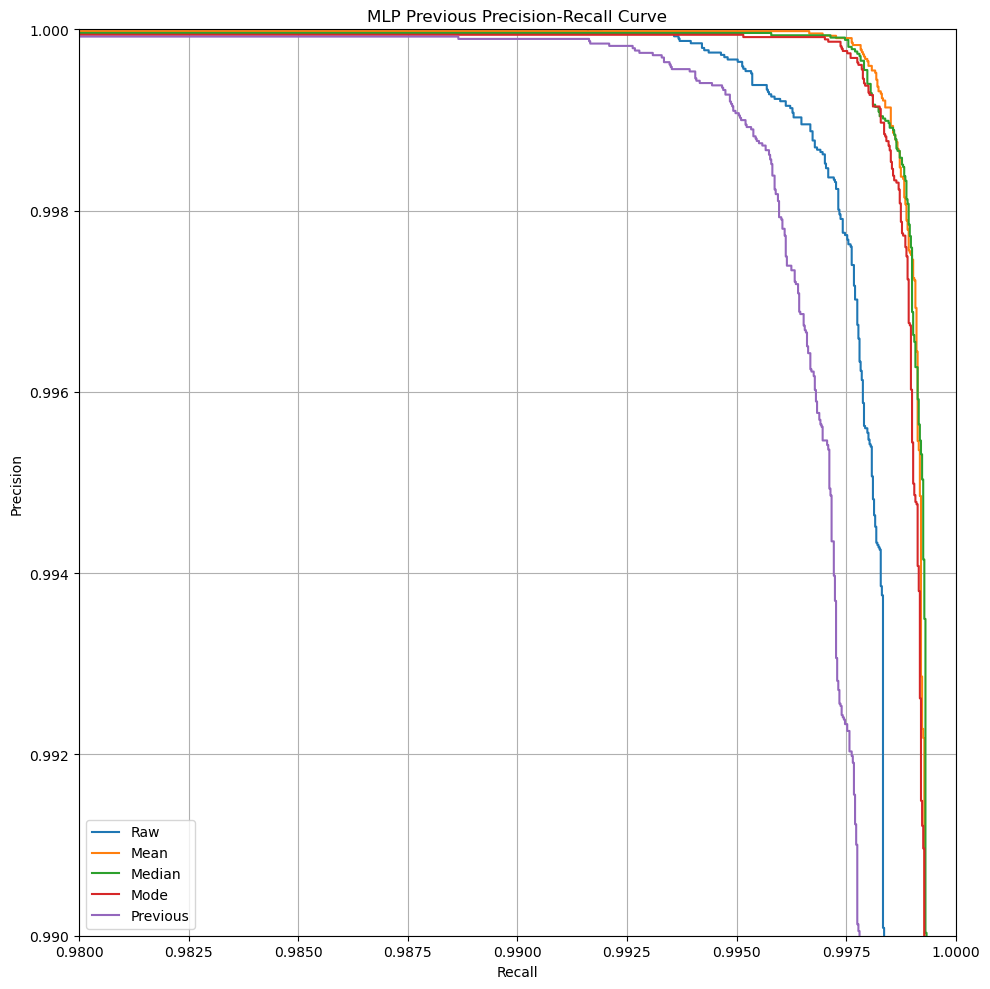

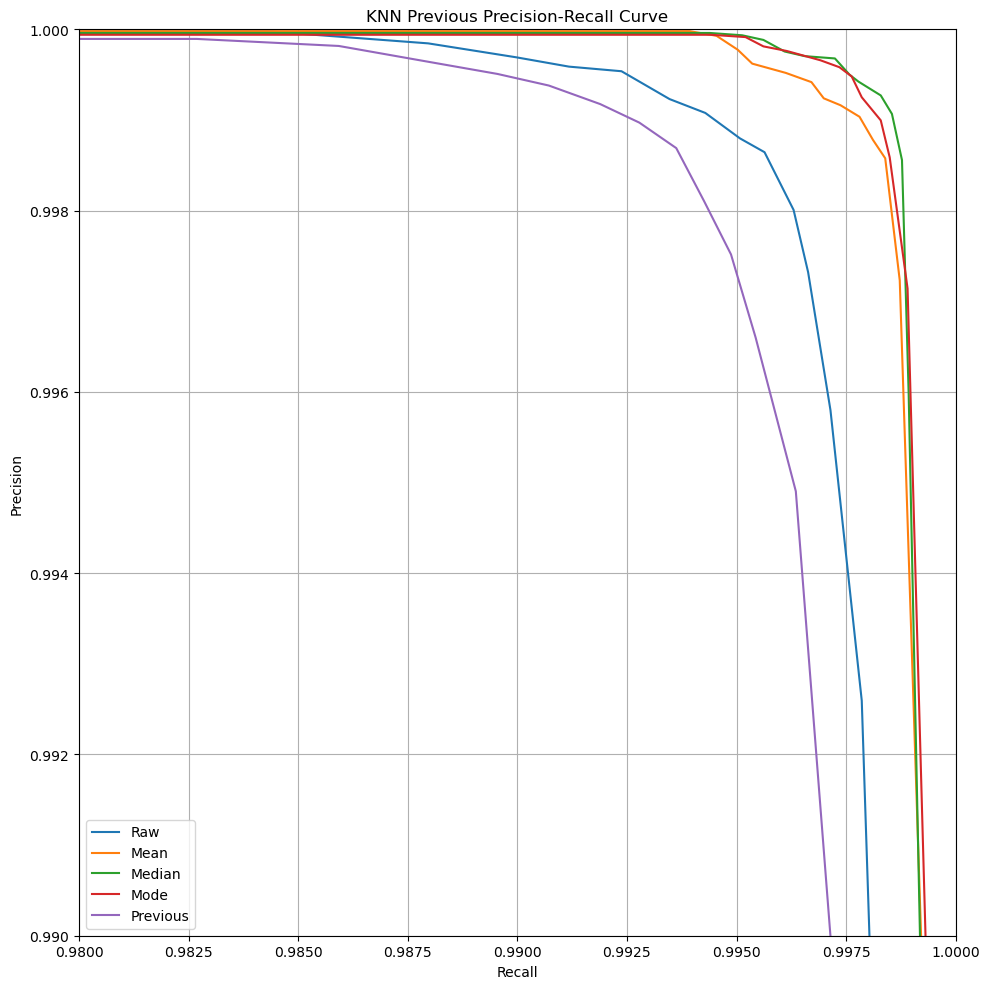

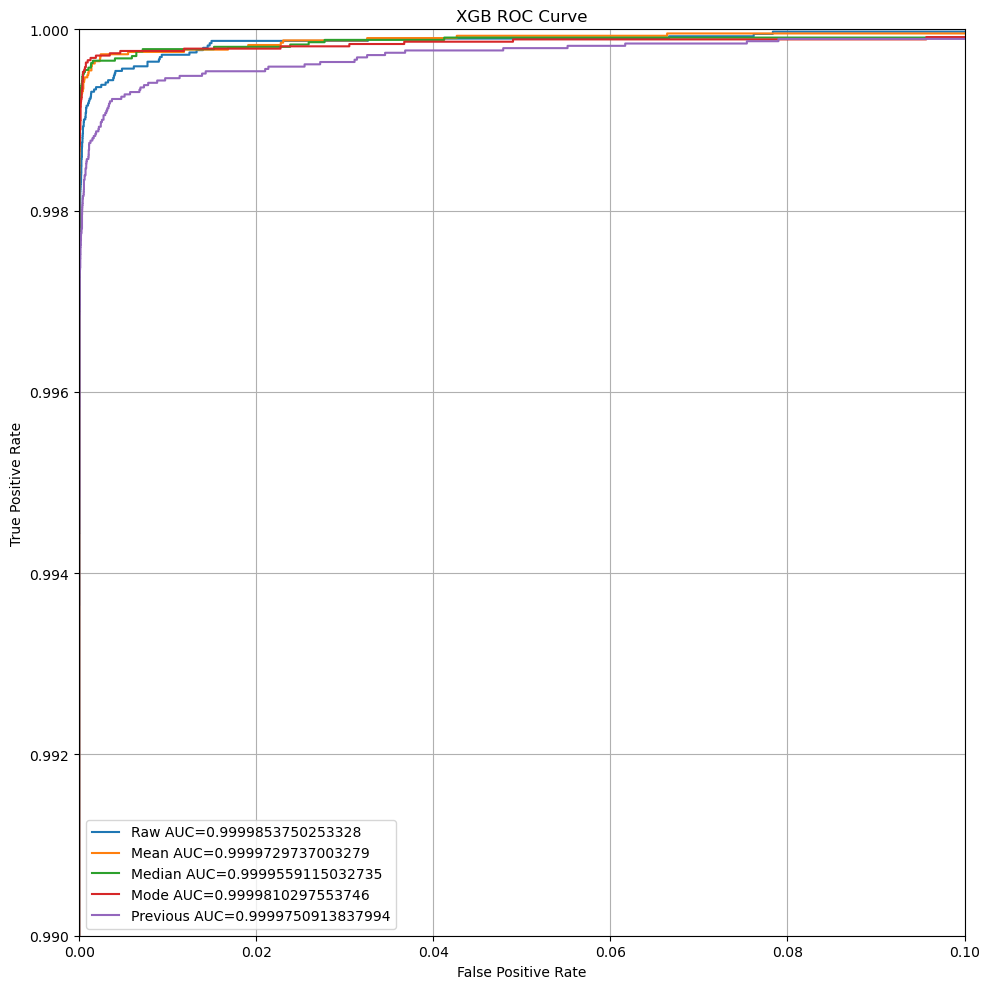

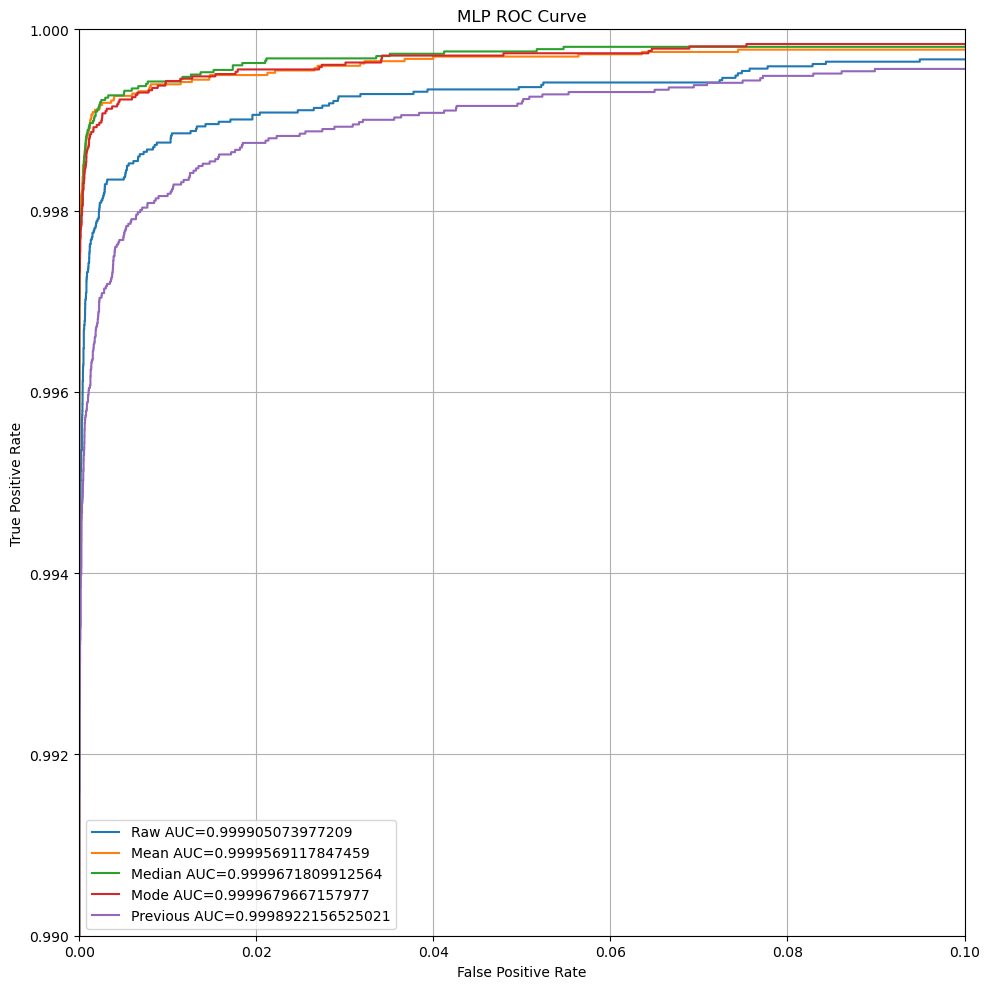

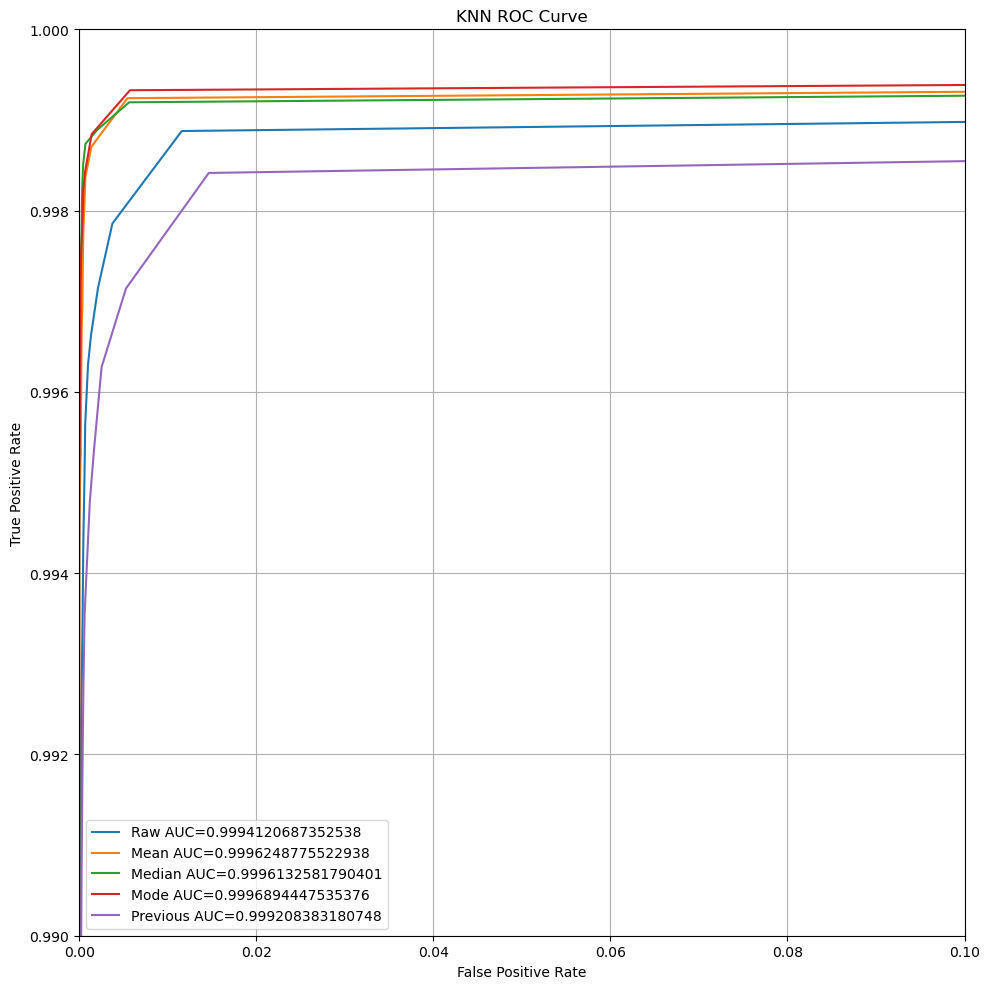

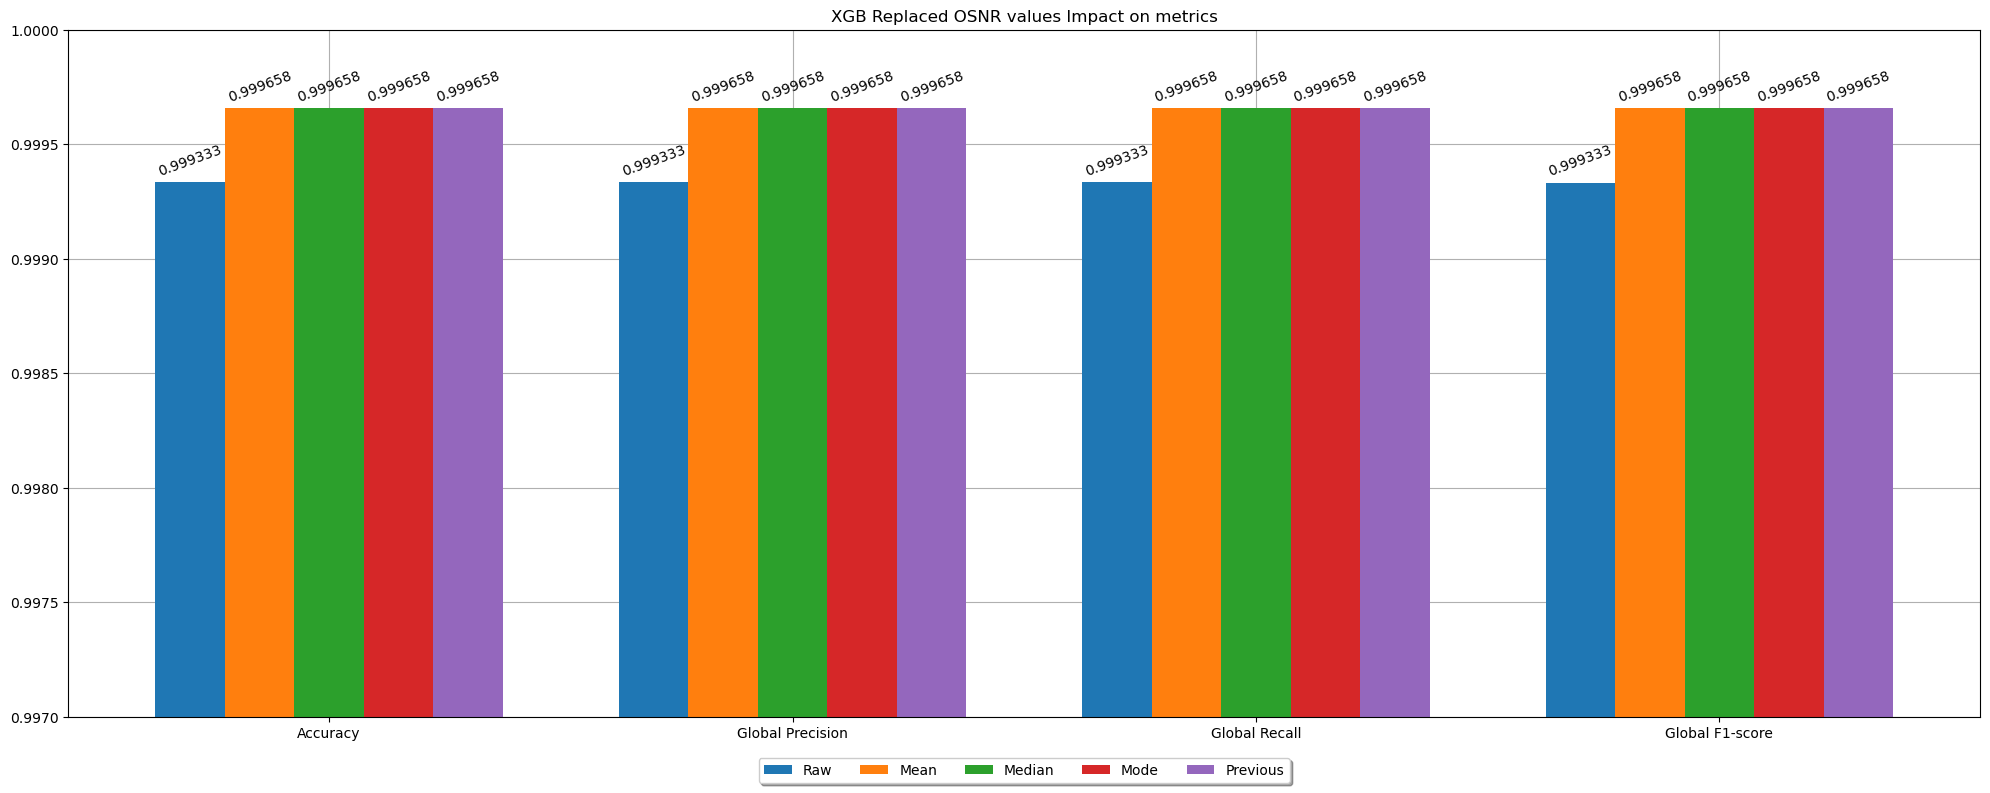

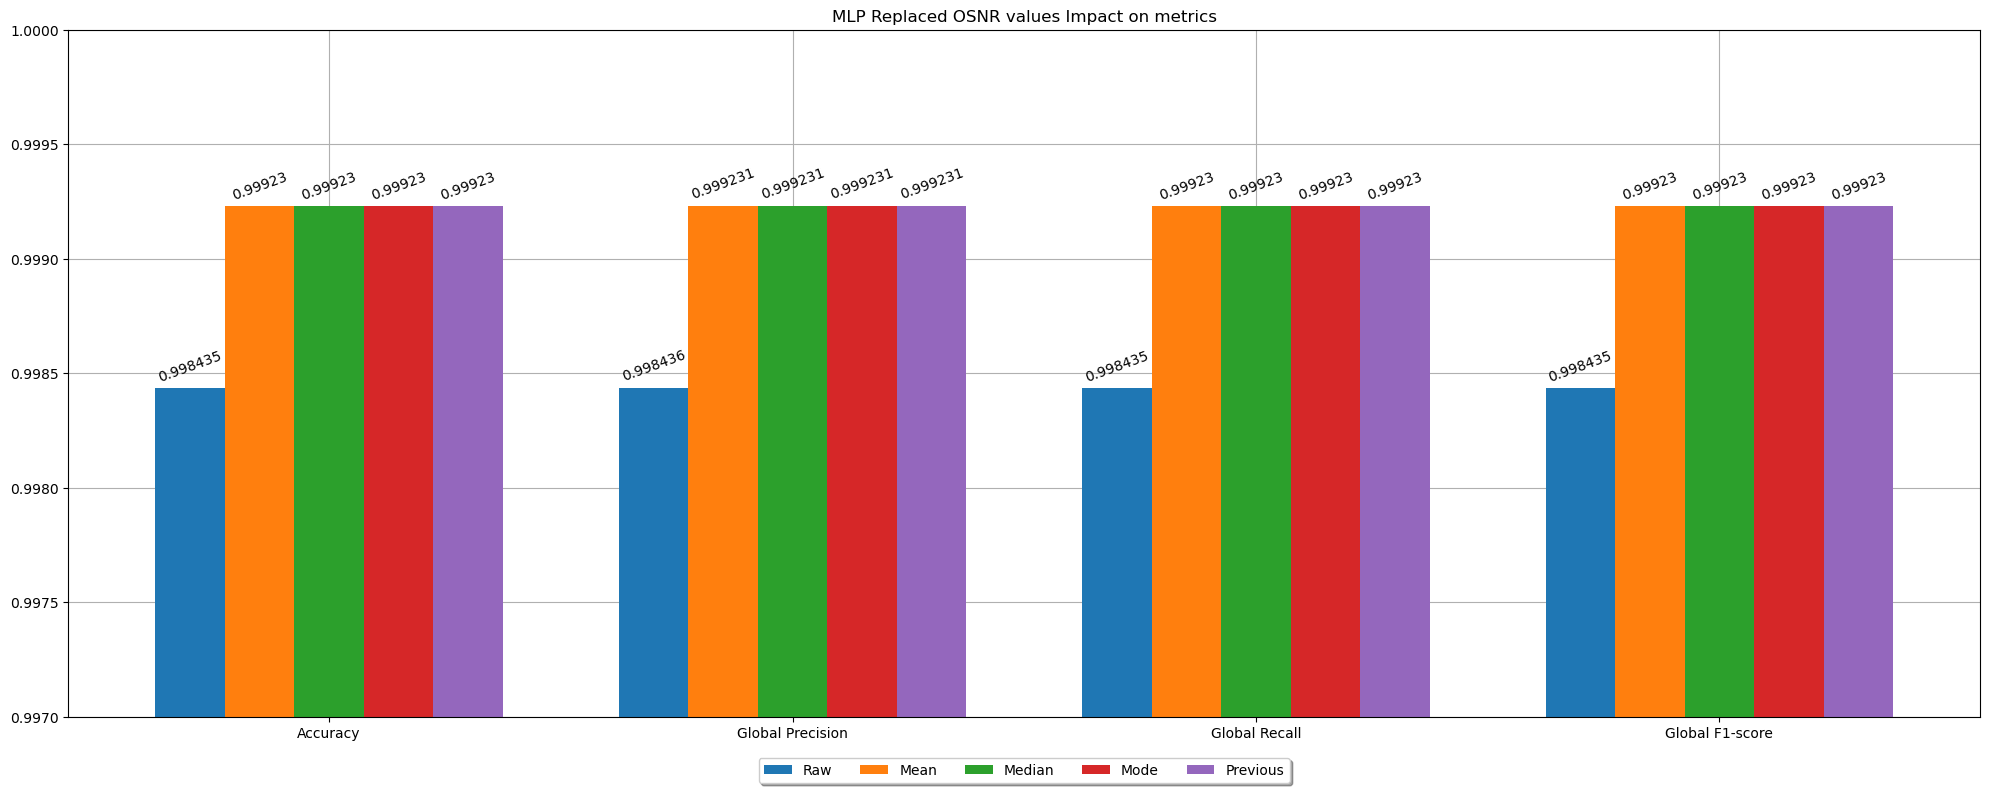

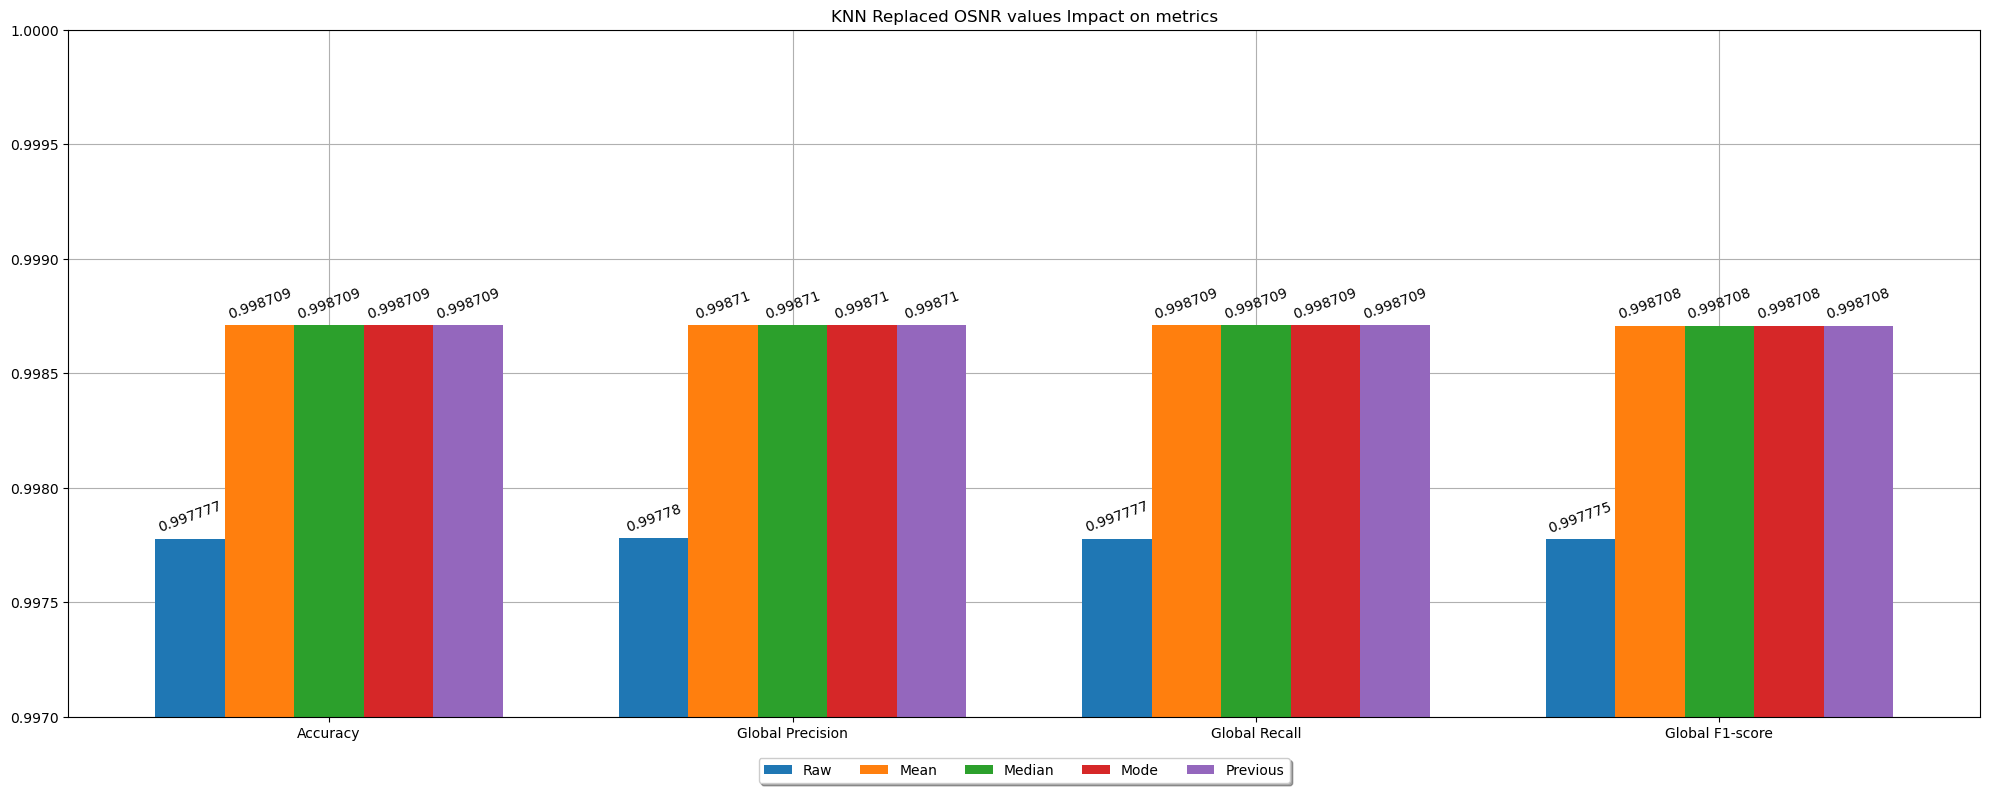

In [26]:
fig_folder = '1_5_Figures'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)
        
# PR curve
plot_precision_recall_curve(fig_folder, 'XGB', xgb_stats_raw[1], xgb_stats_mean[1], xgb_stats_median[1], xgb_stats_mode[1], xgb_stats_previous[1])
plot_precision_recall_curve(fig_folder, 'MLP', dnn_stats_raw[1], dnn_stats_mean[1], dnn_stats_median[1], dnn_stats_mode[1], dnn_stats_previous[1])
plot_precision_recall_curve(fig_folder, 'KNN', knn_stats_raw[1], knn_stats_mean[1], knn_stats_median[1], knn_stats_mode[1], knn_stats_previous[1])

# ROC curve
plot_roc_curve(fig_folder, 'XGB', xgb_stats_raw[0], xgb_stats_mean[0], xgb_stats_median[0], xgb_stats_mode[0], xgb_stats_previous[0])
plot_roc_curve(fig_folder, 'MLP', dnn_stats_raw[0], dnn_stats_mean[0], dnn_stats_median[0], dnn_stats_mode[0], dnn_stats_previous[0])
plot_roc_curve(fig_folder, 'KNN', knn_stats_raw[0], knn_stats_mean[0], knn_stats_median[0], knn_stats_mode[0], knn_stats_previous[0])

# Stats charts
stats_labels= ['Accuracy', 'Global Precision', 'Global Recall', 'Global F1-score']
bar_chart_norm_impact(fig_folder, 'XGB', stats_labels, xgb_stats_raw[2], xgb_stats_mean[2], xgb_stats_median[2], xgb_stats_mode[2], xgb_stats_previous[2])
bar_chart_norm_impact(fig_folder, 'MLP', stats_labels, dnn_stats_raw[2], dnn_stats_mean[2], dnn_stats_median[2], dnn_stats_mode[2], dnn_stats_previous[2])
bar_chart_norm_impact(fig_folder, 'KNN', stats_labels, knn_stats_raw[2], knn_stats_mean[2], knn_stats_median[2], knn_stats_mode[2], knn_stats_previous[2])
